# Understanding Probe at Position Results 
This document explores the data that the tp.data.query.probe_at_position() PyTecplot function returns through both a ordered and FE 2D data example.

Read on for more info...

## We'll start by creating some example data

In [1]:
import tecplot as tp
from tecplot.constant import *
tp.new_layout()

# Create an ordered zone
tp.macro.execute_command('''$!CreateRectangularZone 
  IMax = 3
  JMax = 3
  KMax = 1
  X1 = 0
  Y1 = 0
  Z1 = 0
  X2 = 1
  Y2 = 1
  Z2 = 1
  XVar = 1
  YVar = 2''')

# Create an unstructured zone
tp.macro.execute_command('''$!Triangulate 
  SourceZones =  [1]
  BoundaryZones =  []
  UseBoundary = No
  IncludeBoundaryPts = No
  TriangleKeepFactor = 0.25''')

ds = tp.active_frame().dataset

# Add a Cell-Centered Pressure variable
tp.data.operate.execute_equation('{Pressure} = {X} + {Y}', value_location=ValueLocation.CellCentered)

# Probing IJ-Ordered data
In the examples below we're going to probe IJ-Ordered data at a specific XY location. The images shown below indicate the location at which we probe. The first image shows the node and cell index values. The second image shows the values of the Pressure variable at the cell centers and at the nodes.

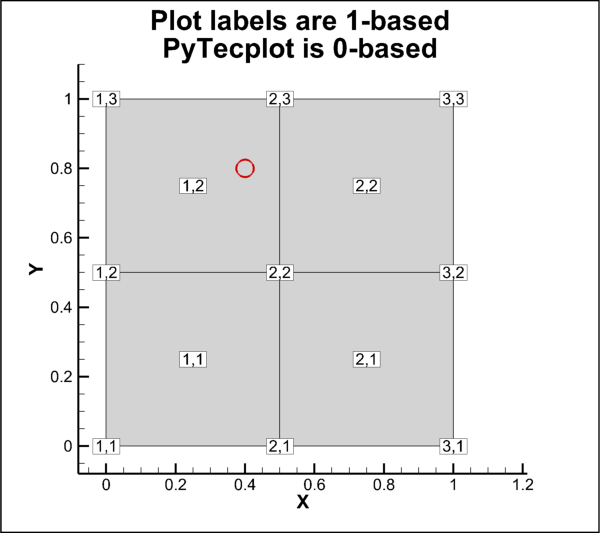

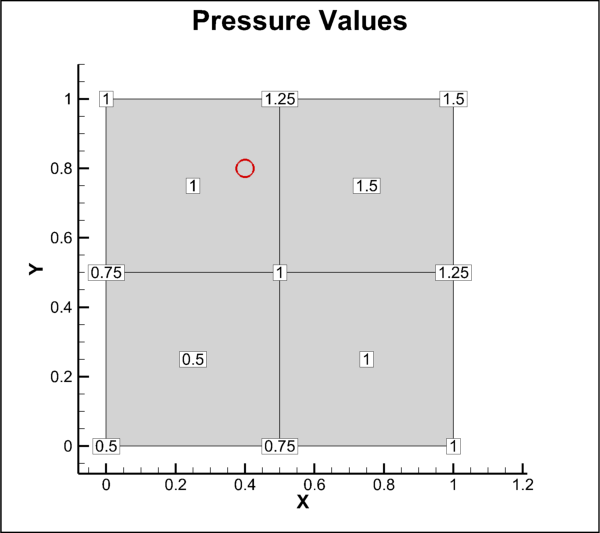

In [2]:
# Hide the unstructured zone
tp.active_frame().plot().fieldmap(ds.zone(1)).show = False

plot = tp.active_frame().plot()
plot.show_mesh=True
plot.data_labels.show_node_labels=True
plot.data_labels.show_cell_labels=True
plot.axes.x_axis.min=-0.08
plot.axes.x_axis.max=1.2
plot.axes.y_axis.min=-0.08
plot.axes.y_axis.max=1.1

text = tp.active_frame().add_text("Plot labels are 1-based\nPyTecplot is 0-based", position=(50,98), anchor=TextAnchor.HeadCenter, size=30)
# Add a circle to represent the probe location
circle = tp.active_frame().add_circle((0.4,0.8), .025, CoordSys.Grid)
circle.color = Color.Red
circle.line_thickness = 0.4
tp.extension.ipython.show()

text.text_string = "Pressure Values"
plot.data_labels.cell_label_type=LabelType.VarValue
plot.data_labels.cell_variable = ds.variable("Pressure")
plot.data_labels.node_label_type=LabelType.VarValue
plot.data_labels.node_variable = ds.variable("Pressure")
tp.extension.ipython.show()

## Probe the cell at X=0.4, Y=0.8
Note that we're using "nearest=False" which will probe at the exact supplied XY[Z] and will return variable values that are interpolated to that location.

In [3]:
res = tp.data.query.probe_at_position(0.4, 0.8, nearest=False, zones=[ds.zone(0)])
print(res)

ProbeResult(data=[0.4, 0.8, 1.1], cell=(0, 1, 0), zone=Zone(uid=24, dataset=Dataset(uid=21, frame=Frame(uid=12, page=Page(uid=11)))))


### Retrieve the variable values at the probed location

In [4]:
# res.data is dimensioned by the number of variables in the dataset
print(res.data)
print(res.data[ds.variable("X").index])
print(res.data[ds.variable("Y").index])
print(res.data[ds.variable("Pressure").index], "<-- This is an interpolated value at X=0.4, Y=0.8")

[0.4, 0.8, 1.1]
0.4
0.8
1.1 <-- This is an interpolated value at X=0.4, Y=0.8


### Retrieve the cell information at the probed location
Remember that PyTecplot delivers 0-based cell indices

In [5]:
# Cell is a three valued tuple holding the 0-based IJK indices of the *cell* that was probed.
print("Cell Index:",res.cell,"<-- These are cell indices since we did a cell probe")
print("I:", res.cell[0])
print("J:", res.cell[1])
print("K:", res.cell[2], "<-- Ignore since we only have an IJ-Ordered zone")

Cell Index: (0, 1, 0) <-- These are cell indices since we did a cell probe
I: 0
J: 1
K: 0 <-- Ignore since we only have an IJ-Ordered zone


### Retrieve the zone information at the probed location

In [6]:
print(res.zone)

Zone: 'Rectangular zone'
  Type: Ordered
  Shape: (3, 3, 1)


### How do I retrieve the Cell Centered value of Pressure for Ordered data?
Make sure to use "nearest=False" to probe the cell. Probing will always return a value interpolated to the probed location (or node). For cell-centered variables you may want to get the exact cell centered value. To do this you need to access the value for the specific cell in the raw data array.

For ordered data, the IJK values must be converted to a cell index. This is done by formula.

In [7]:
import ordered_cell_index as oci #see this script in GitHub

res = tp.data.query.probe_at_position(0.4, 0.8, nearest=False, zones=[ds.zone(0)]) #probing the ordered data
i,j,k = res.cell
print(i,j,k)
# Convert the IJK indicies to a cell_index
cell_index = oci.cell_index(res.zone, i, j, k) # See the cell_index() function in ordered_cell_index.py
print("Cell Index:", cell_index)
print("Pressure:", ds.variable("Pressure").values(res.zone)[cell_index])

0 1 0
Cell Index: 3
Pressure: 1.0


## Probe the nearest node to X=0.4, Y=0.8
Note that we're using "nearest=True" which will find the node nearest the probe location and return variable values at that node.  Cell-centered variable values will be interpolated to the node location.

In [8]:
res = tp.data.query.probe_at_position(0.4, 0.8, nearest=True, zones=[ds.zone(0)])
print(res.data)
print("Pressure value at the nearest node:", res.data[ds.variable("Pressure").index])
print("Node Index:", res.cell, "<-- These are node indices since we probed the nearest node")
print("I:", res.cell[0])
print("J:", res.cell[1])
print("K:", res.cell[2], "<-- Ignore since we only have an IJ-Ordered zone")

[0.4, 0.8, 1.25]
Pressure value at the nearest node: 1.25
Node Index: (1, 2, 0) <-- These are node indices since we probed the nearest node
I: 1
J: 2
K: 0 <-- Ignore since we only have an IJ-Ordered zone


# Probing Unstructured Data
In the examples below we're going to probe Unstructured (FE-Triangle) data at a specific XY location. The images shown below indicate the location at which we probe. The first image shows the node and cell index values. The second image shows the values of the Pressure variable at the cell centers and at the nodes.

Note that retrieval of the variable values and zone information is the same as for ordered data.  Cell retrieval is different and noted below.

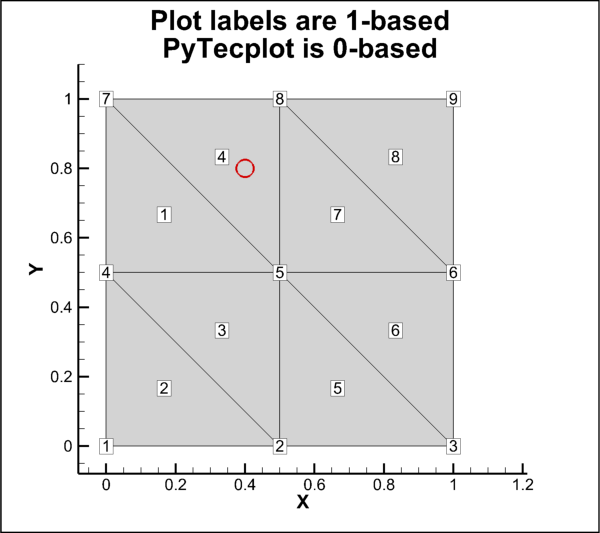

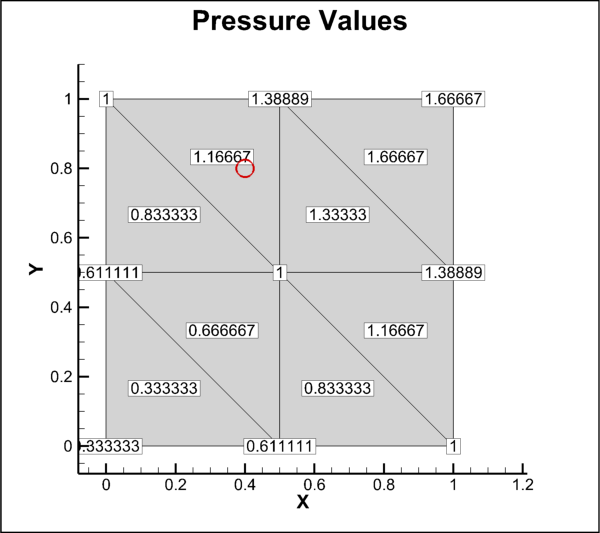

In [9]:
# Show the unstructured zone
tp.active_frame().plot().fieldmap(ds.zone(0)).show = False
tp.active_frame().plot().fieldmap(ds.zone(1)).show = True

text.text_string = "Plot labels are 1-based\nPyTecplot is 0-based"
plot.data_labels.cell_label_type=LabelType.Index
plot.data_labels.node_label_type=LabelType.Index
tp.extension.ipython.show()

text.text_string = "Pressure Values"
plot.data_labels.cell_label_type=LabelType.VarValue
plot.data_labels.cell_variable = ds.variable("Pressure")
plot.data_labels.node_label_type=LabelType.VarValue
plot.data_labels.node_variable = ds.variable("Pressure")
tp.extension.ipython.show()

## Probe the cell at X=0.4, Y=0.8

In [10]:
res = tp.data.query.probe_at_position(0.4, 0.8, nearest=False, zones=[ds.zone(1)])
print("Pressure value:", res.data[ds.variable("Pressure").index], "<-- This is an interpolated value at X=0.4, Y=0.8")

# Cell is a three valued tuple of Node Index, Cell Index, Ignore
print(res.cell)
print("Node Index:", res.cell[0], "<--Ignore this value, since we probed the cell")
print("Cell Index:", res.cell[1])
print("Ignore:", res.cell[2],"<--Ignore this value for unstructured data")

Pressure value: 1.155555534362793 <-- This is an interpolated value at X=0.4, Y=0.8
(1, 3, -1)
Node Index: 1 <--Ignore this value, since we probed the cell
Cell Index: 3
Ignore: -1 <--Ignore this value for unstructured data


## Probe the nearest node to X=0.4, Y=0.8

In [11]:
res = tp.data.query.probe_at_position(0.4, 0.8, nearest=True, zones=[ds.zone(1)])
print("Pressure value:", res.data[ds.variable("Pressure").index], "<-- value at the node, compare to plot above")

# Cell is a three valued tuple of Node Index, Cell Index, Ignore
print(res.cell)
print("Node Index:", res.cell[0], "<-- Use this value since we probed the node")
print("Cell Index:", res.cell[1])
print("Ignore:", res.cell[2],"<--Ignore this value for unstructured data")

Pressure value: 1.3888888359069824 <-- value at the node, compare to plot above
(7, 3, -1)
Node Index: 7 <-- Use this value since we probed the node
Cell Index: 3
Ignore: -1 <--Ignore this value for unstructured data


### How do I retrieve the Cell Centered value of Pressure for Unstructured data?
Then use the cell index to access the cell centered variable array directly.

In [12]:
res = tp.data.query.probe_at_position(0.4, 0.8, nearest=False, zones=[ds.zone(1)])
# Retrieve the cell_index of the probed cell
probed_cell = res.cell[1]
print("Probed cell:", probed_cell)
# Directly accessing the probed cell index in the Pressure data array
print("Pressure:",ds.variable("Pressure").values(res.zone)[probed_cell])

Probed cell: 3
Pressure: 1.1666666269302368
